In [1]:
# load and concatenate waverider data
import numpy as np
import  json
import datetime as dt
import matplotlib.pyplot as plt
#import xarray as xr
import netCDF4
import os
import pandas as pd
from IPython.display import display, HTML
#from scipy import interpolate, signal
#from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
%matplotlib inline

D:221p1_historic.nc
odict_keys(['sourceFilename', 'waveTime', 'waveTimeBounds', 'waveFlagPrimary', 'waveFlagSecondary', 'waveHs', 'waveTp', 'waveTa', 'waveDp', 'wavePeakPSD', 'waveTz', 'waveSourceIndex', 'waveFrequency', 'waveFrequencyBounds', 'waveFrequencyFlagPrimary', 'waveFrequencyFlagSecondary', 'waveBandwidth', 'waveEnergyDensity', 'waveMeanDirection', 'waveA1Value', 'waveB1Value', 'waveA2Value', 'waveB2Value', 'waveCheckFactor', 'waveSpread', 'waveM2Value', 'waveN2Value', 'sstTime', 'sstTimeBounds', 'sstFlagPrimary', 'sstFlagSecondary', 'sstSeaSurfaceTemperature', 'sstSourceIndex', 'sstReferenceTemp', 'gpsTime', 'gpsTimeBounds', 'gpsStatusFlags', 'gpsLatitude', 'gpsLongitude', 'gpsSourceIndex', 'dwrTime', 'dwrTimeBounds', 'dwrSourceIndex', 'dwrBatteryLevel', 'dwrZAccelerometerOffset', 'dwrXAccelerometerOffset', 'dwrYAccelerometerOffset', 'dwrOrientation', 'dwrInclination', 'dwrBatteryWeeksOfLife', 'metaStationName', 'metaStationLatitude', 'metaStationLongitude', 'metaPlatform', 

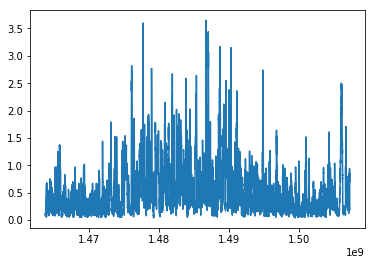

In [6]:
dirname = r'D:'
fname = '221p1_historic.nc'
fpath = os.path.join(dirname,fname)
print(fpath)
nc = netCDF4.Dataset(fpath)
print(nc.variables.keys())
print(nc['waveTime'].units)
Hs = nc['waveHs']
Tp = nc['waveTp']
Ta = nc['waveTa']
Dp = nc['waveDp']

t = nc['waveTime']
plt.plot(t,Hs)